In [1]:
# Create generators to wrap images and labels
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

batch_size = 5
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    directory='food/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False, # Avoid shuffling so labels can be recreated
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory='food/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False, # Avoid shuffling so labels can be recreated
    seed=42
)

Using TensorFlow backend.


Found 60 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


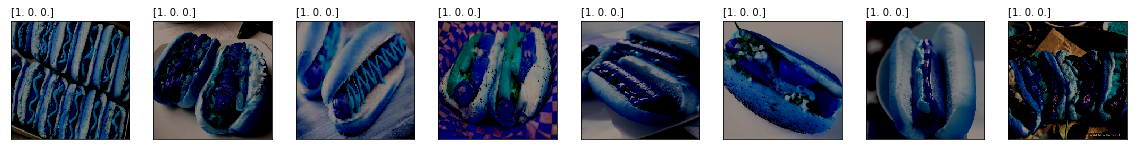

In [2]:
# Plot the first 8 training images and show the corresponding labels
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

images = np.concatenate([train_generator[0][0], train_generator[1][0]]) # First 10 images
labels = np.concatenate([train_generator[0][1], train_generator[1][1]]) # First 10 labels

fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.text(0.0, 1.05, str(labels[i]), transform=ax.transAxes)
    
train_generator.reset()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


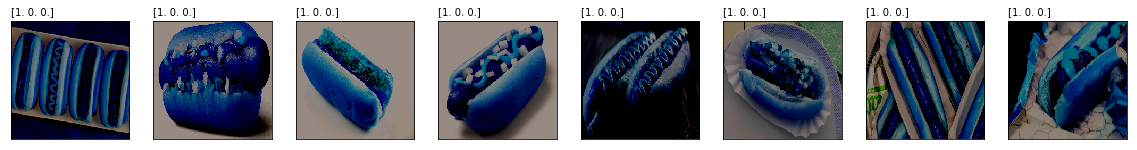

In [3]:
# Plot the first 8 test images and show the corresponding labels
images = np.concatenate([test_generator[0][0], test_generator[1][0]]) # First 10 images
labels = np.concatenate([test_generator[0][1], test_generator[1][1]]) # First 10 labels

fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.text(0.0, 1.05, str(labels[i]), transform=ax.transAxes)
    
test_generator.reset()

In [4]:
# Load ResNet50V2 without a classification layer and run all the images through it to generate training and testing data
from keras.applications import ResNet50V2

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

train_x = base_model.predict_generator(train_generator, train_generator.samples // batch_size)
test_x = base_model.predict_generator(test_generator, test_generator.samples // batch_size)

train_generator.reset()
test_generator.reset()

In [5]:
# Generate labels for training and testing
train_y = []
iterations = train_generator.samples // batch_size

for i in range(iterations):
    train_y.extend(np.array(train_generator[i][1]))

train_y = np.array(train_y)

test_y = []
iterations = test_generator.samples // batch_size

for i in range(iterations):
    test_y.extend(np.array(test_generator[i][1]))
    
test_y = np.array(test_y)

In [6]:
# Build a network for classification and train it with the output from ResNet50V2
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(Flatten(input_shape=train_x.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

hist = model.fit(train_x, train_y, epochs=20, batch_size=batch_size, validation_data=(test_x, test_y))

Train on 60 samples, validate on 30 samples
Epoch 1/20
60/60 [==============================] - 95s 2s/step - loss: 9.6052 - acc: 0.5833 - val_loss: 2.3468 - val_acc: 0.8333
Epoch 2/20
60/60 [==============================] - 16s 261ms/step - loss: 1.1693 - acc: 0.9333 - val_loss: 1.2817 - val_acc: 0.9333
Epoch 3/20
60/60 [==============================] - 16s 268ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.7044 - val_acc: 0.9333
Epoch 4/20
60/60 [==============================] - 17s 279ms/step - loss: 0.2901 - acc: 0.9833 - val_loss: 2.4496 - val_acc: 0.9000
Epoch 5/20
60/60 [==============================] - 16s 266ms/step - loss: 3.1788e-06 - acc: 1.0000 - val_loss: 4.1593 - val_acc: 0.9000
Epoch 6/20
60/60 [==============================] - 15s 257ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.6109 - val_acc: 0.9000
Epoch 7/20
60/60 [==============================] - 16s 265ms/step - loss: 0.3171 - acc: 0.9833 - val_loss: 2.6208 - val_acc: 0.9333
Epoch 8/20
60/60

[]

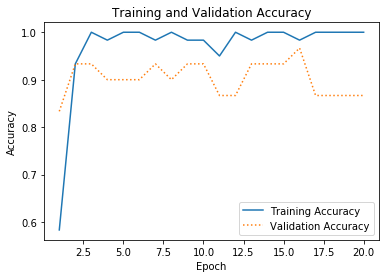

In [7]:
# Plot training accuracy and validation accuracy over time
acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()